## Performance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm

def simulate_concept_covariate(
    n_years=50, n_samples_per_year=5000, n_cont=15, n_bin=4, seed=42,
    cov_mode="permute", cov_scale=1.0, concept_strength=1.0
):
    np.random.seed(seed)
    n_features = n_cont + n_bin

    coef_A = np.random.uniform(-2, 2, size=n_features)
    coef_B = coef_A + concept_strength * np.random.uniform(-5, 5, size=n_features)

    alpha = np.linspace(0, 1, n_years)

    if cov_mode == "permute":
        alpha_x = np.random.permutation(alpha)
    elif cov_mode == "none":
        alpha_x = np.zeros_like(alpha)
    elif cov_mode == "linear":
        alpha_x = alpha.copy()
    elif cov_mode == "sin":
        alpha_x = 0.5 * (1 - np.cos(np.linspace(0, np.pi, n_years)))
    else:
        raise ValueError("Unknown cov_mode")

    dfs, coefs_by_year = [], []
    for year, (a, ax) in enumerate(zip(alpha, alpha_x), start=1):
        cont_means = cov_scale * np.linspace(-2, 2, n_cont) * ax
        X_cont = np.random.normal(loc=cont_means, scale=1.0, size=(n_samples_per_year, n_cont))

        bin_probs = 0.1 + cov_scale * (np.linspace(0, 0.8, n_bin) * ax)
        bin_probs = np.clip(bin_probs, 0.02, 0.98)
        X_bin = np.random.binomial(1, bin_probs, size=(n_samples_per_year, n_bin))

        X = np.hstack([X_cont, X_bin])

        beta_t = (1 - a) * coef_A + a * coef_B
        probs = expit(X @ beta_t)
        y = np.random.binomial(1, probs)

        df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(n_features)])
        df["y"] = y
        df["year"] = year
        dfs.append(df)
        coefs_by_year.append(beta_t)

    return pd.concat(dfs, ignore_index=True), np.vstack(coefs_by_year)


def bernoulli_js_mean(p, q, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    q = np.clip(q, eps, 1 - eps)
    m = 0.5 * (p + q)
    kl_pm = p * np.log(p / m) + (1 - p) * np.log((1 - p) / (1 - m))
    kl_qm = q * np.log(q / m) + (1 - q) * np.log((1 - q) / (1 - m))
    return float(0.5 * np.mean(kl_pm + kl_qm))

def oracle_concept_shift_on_testX(coefs_by_year, window_years, test_year, X_test, weights=None):
    betas = coefs_by_year
    beta_test = betas[test_year - 1]
    p_test = expit(X_test @ beta_test)
    P_list = [expit(X_test @ betas[t - 1]) for t in window_years]  # list of (n_test,)
    P_stack = np.column_stack(P_list)                               # (n_test, |W|)
    if weights is None:
        p_train = P_stack.mean(axis=1)
    else:
        w = np.asarray(weights, dtype=float); w = w / w.sum()
        p_train = P_stack @ w
    return bernoulli_js_mean(p_train, p_test)


def cramers_v(ct):
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.values.sum()
    r, c = ct.shape
    phi2 = chi2 / n
    denom = max(1, min(r - 1, c - 1))
    return np.sqrt(phi2 / denom)

def covariate_shift_A_style(train_df, test_df, df_all, year_y, test_year, feature_cols):
    binary_vars = [c for c in feature_cols if train_df[c].nunique() == 2]
    continuous_vars = [c for c in feature_cols if c not in binary_vars]
    cov_shift_scores = {}
    try:
        if len(continuous_vars) > 0:
            cont_train = train_df[continuous_vars].dropna()
            cont_test = test_df[continuous_vars].dropna()
            if len(cont_train) > 0 and len(cont_test) > 0:
                scaler = StandardScaler().fit(cont_train)
                train_scaled = scaler.transform(cont_train)
                test_scaled = scaler.transform(cont_test)
                pca = PCA(n_components=min(5, len(continuous_vars)))
                train_pca = pca.fit_transform(train_scaled)
                test_pca = pca.transform(test_scaled)
                ks_vals = [ks_2samp(train_pca[:, i], test_pca[:, i]).statistic
                           for i in range(pca.n_components_)]
                cov_shift_scores['pca_shift'] = float(np.mean(ks_vals))
            else:
                cov_shift_scores['pca_shift'] = np.nan
        else:
            cov_shift_scores['pca_shift'] = np.nan
    except Exception as e:
        print(f"[WARN] PCA shift failed for year {year_y}: {e}")
        cov_shift_scores['pca_shift'] = np.nan

    try:
        if len(binary_vars) > 0:
            delta_props, cramers_vs = [], []
            for feature in binary_vars:
                if feature not in train_df.columns or feature not in test_df.columns:
                    continue
                p_train = train_df[feature].mean()
                p_test = test_df[feature].mean()
                delta_props.append(abs(p_train - p_test))

                df_temp = df_all[df_all['year'].isin([year_y, test_year])]
                ct = pd.crosstab(df_temp['year'], df_temp[feature])
                if ct.shape[0] >= 2 and ct.shape[1] >= 2:
                    cramers_vs.append(cramers_v(ct))

            if delta_props and cramers_vs:
                cov_shift_scores['binary_shift'] = float((np.mean(delta_props) + np.mean(cramers_vs)) / 2.0)
            else:
                cov_shift_scores['binary_shift'] = np.nan
        else:
            cov_shift_scores['binary_shift'] = np.nan
    except Exception as e:
        print(f"[WARN] Binary shift failed for year {year_y}: {e}")
        cov_shift_scores['binary_shift'] = np.nan

    unified = np.nanmean([cov_shift_scores.get('pca_shift'), cov_shift_scores.get('binary_shift')])
    return cov_shift_scores.get('pca_shift'), cov_shift_scores.get('binary_shift'), unified


def evaluate_merged_pipeline_oracle(df_all, coefs_by_year, test_year=50):
    feature_cols = [c for c in df_all.columns if c.startswith("x")]
    results = []
    test_df = df_all[df_all["year"] == test_year]
    X_te = test_df[feature_cols].values

    for y in range(test_year - 1, 0, -1):
        train_df = df_all[df_all["year"].between(y, test_year - 1)]
        if train_df["y"].nunique() < 2 or test_df["y"].nunique() < 2:
            continue

        model = LogisticRegression(max_iter=1000, solver="lbfgs")
        model.fit(train_df[feature_cols], train_df["y"])
        y_prob = model.predict_proba(X_te)[:, 1]
        auc = roc_auc_score(test_df["y"], y_prob)

        cov_pca, cov_bin, cov_unified = covariate_shift_A_style(
            train_df, test_df, df_all, year_y=y, test_year=test_year, feature_cols=feature_cols
        )

        window_years = list(range(y, test_year))
        concept_js_oracle = oracle_concept_shift_on_testX(
            coefs_by_year, window_years, test_year, X_te, weights=None
        )

        results.append({
            "window_size": test_year - y,
            "auc": float(auc),
            "concept_shift_js_oracle_on_testX": float(concept_js_oracle),
            "unified_cov_shift": cov_unified,
            "cov_shift_pca": cov_pca,
            "cov_shift_binary": cov_bin,
            "train_start_year": y,
            "train_end_year": test_year - 1,
            "test_year": test_year
        })

    return pd.DataFrame(results)


def make_four_scenarios(n_years=50, n_samples_per_year=5000, n_cont=15, n_bin=4, seed=42):
    configs = {
        "none":         dict(cov_mode="none",     cov_scale=0.0, concept_strength=0.0),
        "cov_only":     dict(cov_mode="permute",  cov_scale=1.0, concept_strength=0.0),
        "concept_only": dict(cov_mode="none",     cov_scale=0.0, concept_strength=1.0),
        "both":         dict(cov_mode="permute",  cov_scale=1.0, concept_strength=1.0),
    }
    out = {}
    for name, cfg in configs.items():
        df_all, coefs = simulate_concept_covariate(
            n_years=n_years, n_samples_per_year=n_samples_per_year,
            n_cont=n_cont, n_bin=n_bin, seed=seed,
            **cfg
        )
        df_eval = evaluate_merged_pipeline_oracle(df_all, coefs, test_year=n_years)
        df_eval["scenario"] = name
        out[name] = {"data": df_all, "betas": coefs, "eval": df_eval}
    return out


if __name__ == "__main__":
    params = dict(n_years=50, n_samples_per_year=5000, n_cont=15, n_bin=4, seed=42)

    results = make_four_scenarios(**params)
    for k in ["none", "cov_only", "concept_only", "both"]:
        print(f"\n=== {k.upper()} ===")
        ev = results[k]["eval"]
        print(ev[["window_size", "auc", "concept_shift_js_oracle_on_testX", "unified_cov_shift"]].head(3))

    df_all_eval = pd.concat([results[k]["eval"] for k in results], ignore_index=True)
    print("\nCorr(concept, covariate) by scenario:")
    for k in results:
        sub = results[k]["eval"]
        print(f"  {k:12s}:", sub["concept_shift_js_oracle_on_testX"].corr(sub["unified_cov_shift"]))


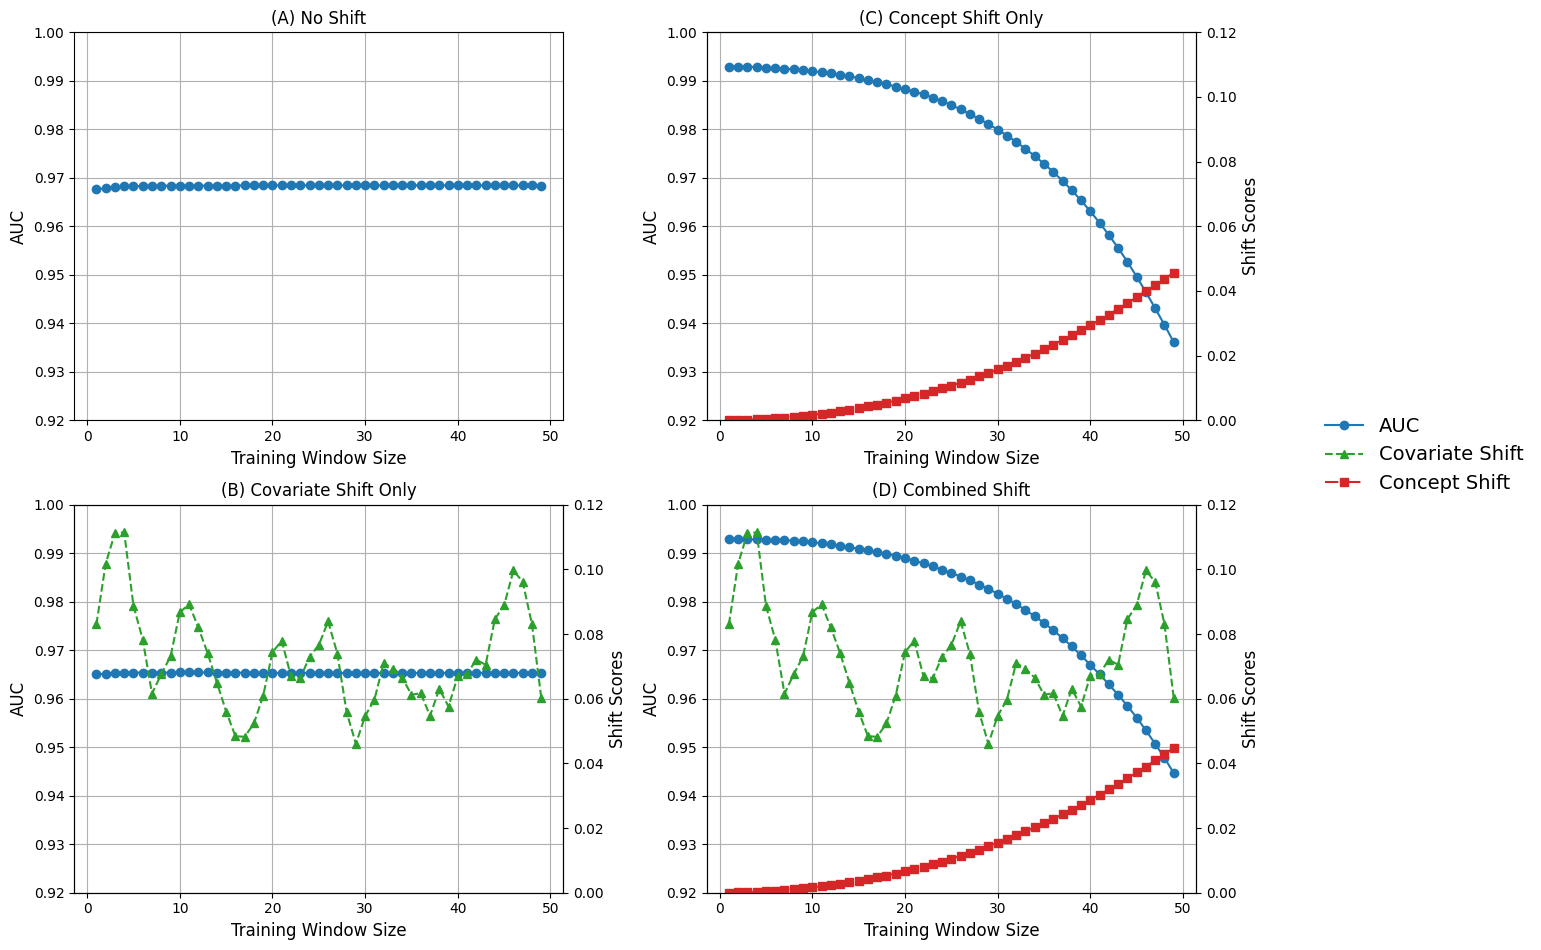

In [27]:


from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def _concept_col(df):
    for c in ["concept_shift_js_oracle_on_testX", "concept_shift_js_decoupled", "concept_shift_js"]:
        if c in df.columns:
            return c
    raise KeyError("Concept shift column not found in df.")

def smooth_series(y, window=7, polyorder=2):
    y = np.asarray(y)
    n = len(y)
    if n < 3: return y
    w = min(window, n if n % 2 == 1 else n - 1)
    if w < 3: return y
    if polyorder >= w: polyorder = max(1, w - 2)
    return savgol_filter(y, window_length=w, polyorder=polyorder)

def plot_four_panels(
    df_none, df_cov_only, df_concept_only, df_both,
    shift_ylim=(0.0, 0.12), auc_ylim=(0.92, 1.0),
    smooth_window=7, polyorder=2
):
    d1 = df_none.sort_values("window_size").reset_index(drop=True)
    d2 = df_concept_only.sort_values("window_size").reset_index(drop=True)
    d3 = df_cov_only.sort_values("window_size").reset_index(drop=True)
    d4 = df_both.sort_values("window_size").reset_index(drop=True)

    concept_2 = _concept_col(d2)
    concept_3 = _concept_col(d3)
    concept_4 = _concept_col(d4)

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3, right=0.82)

    # (A) No shift — AUC only
    ax = axs[0, 0]
    ax.plot(d1["window_size"], smooth_series(d1["auc"], smooth_window, polyorder),
            linestyle='-', marker='o', color='tab:blue')
    ax.set_xlabel("Training Window Size", fontsize=12)
    ax.set_ylabel("AUC", fontsize=12)
    if auc_ylim is not None: ax.set_ylim(*auc_ylim)
    ax.set_title("(A) No Shift")
    ax.grid(True)

    # (B) Covariate-only 
    ax1 = axs[1, 0]; ax2 = ax1.twinx()
    ax1.plot(d3["window_size"], smooth_series(d3["auc"], smooth_window, polyorder),
             linestyle='-', marker='o', color='tab:blue')
    ax2.plot(d3["window_size"], smooth_series(d3["unified_cov_shift"], smooth_window, polyorder),
             linestyle='--', marker='^', color='tab:green', label="Covariate Shift")
    ax1.set_xlabel("Training Window Size", fontsize=12)
    ax1.set_ylabel("AUC", fontsize=12)
    ax2.set_ylabel("Shift Scores", fontsize=12)
    if auc_ylim is not None: ax1.set_ylim(*auc_ylim)
    ax2.set_ylim(*shift_ylim)
    ax1.set_title("(B) Covariate Shift Only")
    ax1.grid(True)

    # (C) Concept-only 
    ax1 = axs[0, 1]; ax2 = ax1.twinx()
    ax1.plot(d2["window_size"], smooth_series(d2["auc"], smooth_window, polyorder),
             linestyle='-', marker='o', color='tab:blue')
    ax2.plot(d2["window_size"], smooth_series(d2[concept_2], smooth_window, polyorder),
             linestyle='-.', marker='s', color='tab:red', label="Concept Shift")
    ax1.set_xlabel("Training Window Size", fontsize=12)
    ax1.set_ylabel("AUC", fontsize=12)
    ax2.set_ylabel("Shift Scores", fontsize=12)
    if auc_ylim is not None: ax1.set_ylim(*auc_ylim)
    ax2.set_ylim(*shift_ylim)
    ax1.set_title("(C) Concept Shift Only")
    ax1.grid(True)

    # (D) Both — AUC + both shifts
    ax1 = axs[1, 1]; ax2 = ax1.twinx()
    ax1.plot(d4["window_size"], smooth_series(d4["auc"], smooth_window, polyorder),
             linestyle='-', marker='o', color='tab:blue')
    ax2.plot(d4["window_size"], smooth_series(d4["unified_cov_shift"], smooth_window, polyorder),
             linestyle='--', marker='^', color='tab:green', label="Covariate Shift")
    ax2.plot(d4["window_size"], smooth_series(d4[concept_4], smooth_window, polyorder),
             linestyle='-.', marker='s', color='tab:red', label="Concept Shift")
    ax1.set_xlabel("Training Window Size", fontsize=12)
    ax1.set_ylabel("AUC", fontsize=12)
    ax2.set_ylabel("Shift Scores", fontsize=12)
    if auc_ylim is not None: ax1.set_ylim(*auc_ylim)
    ax2.set_ylim(*shift_ylim)
    ax1.set_title("(D) Combined Shift")
    ax1.grid(True)

    # Shared legend
    legend_elements = [
        Line2D([0], [0], color='tab:blue',  marker='o', linestyle='-',  label='AUC'),
        Line2D([0], [0], color='tab:green', marker='^', linestyle='--', label='Covariate Shift'),
        Line2D([0], [0], color='tab:red',   marker='s', linestyle='-.', label='Concept Shift'),
    ]
    fig = plt.gcf()
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.82, 0.5),
               frameon=False, fontsize=14)


    plt.tight_layout(rect=[0, 0, 0.80, 0.96])
    fig.savefig('shift_analysis_simulation.png', dpi=500, bbox_inches='tight')
    plt.show()

df_none         = results["none"]["eval"]
df_cov_only     = results["cov_only"]["eval"]
df_concept_only = results["concept_only"]["eval"]
df_both         = results["both"]["eval"]
plot_four_panels(df_none, df_cov_only, df_concept_only, df_both)
# ======================


In [ ]:
def _concept_col(df):
    for c in ["concept_shift_js_oracle_on_testX", "concept_shift_js_decoupled", "concept_shift_js"]:
        if c in df.columns:
            return c
    raise KeyError("No concept shift column found in eval DataFrame.")

def _prep_reg_df(eval_df: pd.DataFrame) -> pd.DataFrame:
    d = eval_df.dropna(subset=["auc"]).copy()
    ccol = _concept_col(d)
    if "unified_cov_shift" not in d.columns:
        raise KeyError("Eval DataFrame must contain 'unified_cov_shift'.")
    d["concept_norm"]   = d[ccol] / np.log(2)            
    d["covariate_norm"] = np.clip(d["unified_cov_shift"], 0.0, 1.0)
    d["interaction"]    = d["concept_norm"] * d["covariate_norm"]
    d = d.dropna(subset=["concept_norm", "covariate_norm", "interaction"])
    return d

def _safe_ols(y: pd.Series, X: pd.DataFrame, add_const: bool = True):
    stds = X.std(axis=0, ddof=0)
    keep = stds[stds > 1e-12].index.tolist()
    X_use = X[keep]
    if add_const:
        X_use = sm.add_constant(X_use, has_constant="add")
    if X_use.shape[1] == 1:
        print("   [WARN] Only constant term remains; skipping regression.")
        return None
    model = sm.OLS(y, X_use).fit()
    return model

def run_four_regressions(results: dict):
    """
    Enforce scenario rules:
      - none:           concept_norm = 1, covariate_norm = 1
      - cov_only:       concept_norm = 1, covariate_norm = data
      - concept_only:   concept_norm = data, covariate_norm = 1
      - both:           concept_norm = data, covariate_norm = data
    Interaction = concept_norm * covariate_norm (constant when any component is constant).
    """
    order = [
        ("none", "No shift"),
        ("cov_only", "Covariate only"),
        ("concept_only", "Concept only"),
        ("both", "Both shifts"),
    ]
    models = {}

    for key, title in order:
        print(f"\n=== Regression — {title} ===")
        eval_df = results[key]["eval"]
        d = _prep_reg_df(eval_df).copy()

        if key == "none":
            d["concept_norm"] = 1.0
            d["covariate_norm"] = 1.0

        elif key == "cov_only":
            if "covariate_norm" not in d.columns:
                raise ValueError("cov_only expects 'covariate_norm' in eval data.")
            d["concept_norm"] = 1.0

        elif key == "concept_only":
            if "concept_norm" not in d.columns:
                raise ValueError("concept_only expects 'concept_norm' in eval data.")
            d["covariate_norm"] = 1.0

        elif key == "both":
            missing = [c for c in ("concept_norm", "covariate_norm") if c not in d.columns]
            if missing:
                raise ValueError(f"both expects both predictors present; missing: {missing}")

        else:
            raise ValueError(f"Unknown scenario key: {key}")
        d["interaction"] = d["concept_norm"] * d["covariate_norm"]

        X = d[["concept_norm", "covariate_norm", "interaction"]]
        y = d["auc"]

        m = _safe_ols(y, X, add_const=True)
        if m is None:
            print("   Model not estimated (predictors degenerate under this scenario).")
        else:
            print(m.summary())
        models[key] = m

    return models

models = run_four_regressions(results)



=== Regression — No shift ===
   [WARN] Only constant term remains; skipping regression.
   Model not estimated (predictors degenerate under this scenario).

=== Regression — Covariate only ===
                            OLS Regression Results                            
Dep. Variable:                    auc   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.4576
Date:                Sun, 09 Nov 2025   Prob (F-statistic):              0.502
Time:                        18:26:01   Log-Likelihood:                 401.80
No. Observations:                  49   AIC:                            -799.6
Df Residuals:                      47   BIC:                            -795.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
               

## fairness

In [ ]:
# ===============================
# 1) Simulation: group-specific concept shift (gender=1 drifts; gender=0 fixed)
# ===============================
def simulate_group_specific_concept_shift(
    n_years=50, n_samples_per_year=5000, n_cont=15, n_bin=4, seed=42
):
    """
    - P(X): constant across years (no covariate shift)
    - P(Y|X): for gender==1, beta_t = (1-a)*beta_A + a*beta_B; for gender==0, beta_t = beta_A (constant)
    - Last binary feature is 'gender'
    Returns:
        df_all: data with columns x1..x{n_cont+n_bin}, y, year
        betas_g0: (n_years, n_features)  (all rows == beta_A)
        betas_g1: (n_years, n_features)  (linear interpolation from beta_A to beta_B)
    """
    np.random.seed(seed)
    n_features = n_cont + n_bin
    coef_A = np.random.uniform(-1, 2, size=n_features)
    coef_B = coef_A + np.random.uniform(-5, 5, size=n_features)

    alphas = np.linspace(0, 1, n_years)
    betas_g0 = np.tile(coef_A, (n_years, 1))
    betas_g1 = np.vstack([(1 - a) * coef_A + a * coef_B for a in alphas])

    dfs = []
    for t, a in enumerate(alphas, start=1):
        X_cont = np.random.normal(0, 1, size=(n_samples_per_year, n_cont))
        X_bin = np.random.binomial(1, 0.5, size=(n_samples_per_year, n_bin))
        X = np.hstack([X_cont, X_bin])

        gender = X[:, -1] 
        beta0 = betas_g0[t - 1]
        beta1 = betas_g1[t - 1]
        logits = (1 - gender) * (X @ beta0) + gender * (X @ beta1)
        y = np.random.binomial(1, expit(logits))

        df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(n_features)])
        df["y"] = y
        df["year"] = t
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True), betas_g0, betas_g1


# ===============================
# 2) Concept shift 
# ===============================
def bernoulli_js_mean(p, q, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    q = np.clip(q, eps, 1 - eps)
    m = 0.5 * (p + q)
    kl_pm = p * np.log(p / m) + (1 - p) * np.log((1 - p) / (1 - m))
    kl_qm = q * np.log(q / m) + (1 - q) * np.log((1 - q) / (1 - m))
    return float(0.5 * np.mean(kl_pm + kl_qm))

def oracle_concept_shift_on_testX_group(betas_g, window_years, test_year, X_test):
    """
    betas_g: shape (n_years, n_features) for a given gender
    window_years: list(range(y, test_year))
    X_test: test-year feature matrix of that gender
    """
    beta_test = betas_g[test_year - 1]
    p_test = expit(X_test @ beta_test)
    p_train = np.mean([expit(X_test @ betas_g[t - 1]) for t in window_years], axis=0)
    return bernoulli_js_mean(p_train, p_test)


# ===============================
# 3) Covariate shift
# ===============================
def cramers_v(ct):
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.values.sum()
    r, c = ct.shape
    phi2 = chi2 / n
    denom = max(1, min(r - 1, c - 1))
    return np.sqrt(phi2 / denom)

def covariate_shift_A_style(train_df, test_df, feature_cols):
    binary_vars = [c for c in feature_cols if train_df[c].nunique() == 2]
    continuous_vars = [c for c in feature_cols if c not in binary_vars]
    scores = {}

    try:
        if len(continuous_vars) > 0:
            tr = train_df[continuous_vars].dropna().values
            te = test_df[continuous_vars].dropna().values
            if len(tr) > 0 and len(te) > 0:
                scaler = StandardScaler().fit(tr)
                tr_s = scaler.transform(tr); te_s = scaler.transform(te)
                pca = PCA(n_components=min(5, tr_s.shape[1])).fit(tr_s)
                tr_pc = pca.transform(tr_s); te_pc = pca.transform(te_s)
                ks_vals = [ks_2samp(tr_pc[:, i], te_pc[:, i]).statistic for i in range(pca.n_components_)]
                scores["pca_shift"] = float(np.mean(ks_vals))
            else:
                scores["pca_shift"] = np.nan
        else:
            scores["pca_shift"] = np.nan
    except Exception as e:
        print(f"[WARN] PCA shift failed: {e}")
        scores["pca_shift"] = np.nan

    try:
        if len(binary_vars) > 0:
            delta_props, cvs = [], []
            for b in binary_vars:
                if b not in train_df.columns or b not in test_df.columns:
                    continue
                delta_props.append(abs(train_df[b].mean() - test_df[b].mean()))
                ct = pd.crosstab(
                    pd.concat([pd.Series(0, index=train_df.index), pd.Series(1, index=test_df.index)], ignore_index=True),
                    pd.concat([train_df[b].reset_index(drop=True), test_df[b].reset_index(drop=True)], ignore_index=True)
                )
                if ct.shape == (2, 2):
                    cvs.append(cramers_v(ct))
            if delta_props and cvs:
                scores["binary_shift"] = float((np.mean(delta_props) + np.mean(cvs)) / 2.0)
            else:
                scores["binary_shift"] = np.nan
        else:
            scores["binary_shift"] = np.nan
    except Exception as e:
        print(f"[WARN] Binary shift failed: {e}")
        scores["binary_shift"] = np.nan

    unified = np.nanmean([scores.get("pca_shift"), scores.get("binary_shift")])
    return scores.get("pca_shift"), scores.get("binary_shift"), unified


def compute_groupwise_shift_metrics_oracle(
    df_all, test_year, feature_cols, gender_col, betas_g0, betas_g1
):
    shifts = []
    test_df = df_all[df_all["year"] == test_year]
    for y in range(test_year - 1, 0, -1):
        train_df = df_all[df_all["year"].between(y, test_year - 1)]
        row = {"train_year": y}

        for g in [0, 1]:
            tr_g = train_df[train_df[gender_col] == g]
            te_g = test_df[test_df[gender_col] == g]
            X_te = te_g[feature_cols].values
            if g == 0:
                js = oracle_concept_shift_on_testX_group(betas_g0, list(range(y, test_year)), test_year, X_te)
            else:
                js = oracle_concept_shift_on_testX_group(betas_g1, list(range(y, test_year)), test_year, X_te)
            row[f"js_gender{g}"] = float(js)

            cov_pca, cov_bin, cov_uni = covariate_shift_A_style(tr_g, te_g, feature_cols)
            row[f"cov_shift_cont_gender{g}"] = cov_pca
            row[f"cov_shift_bin_gender{g}"] = cov_bin
            row[f"unified_cov_shift_gender{g}"] = cov_uni

        shifts.append(row)

    return pd.DataFrame(shifts)


def compute_groupwise_auc_gap_expanding(df_all, test_year, feature_cols, gender_col):
    test_df_full = df_all[df_all["year"] == test_year]
    results = []
    for y in range(test_year - 1, 0, -1):
        train_df = df_all[df_all["year"].between(y, test_year - 1)]
        test_df = test_df_full.copy()
        if train_df["y"].nunique() < 2 or test_df["y"].nunique() < 2:
            results.append({"train_year": y, "auc_gender0": np.nan, "auc_gender1": np.nan, "auc_gap": np.nan})
            continue

        model = LogisticRegression(max_iter=1000, solver="lbfgs")
        model.fit(train_df[feature_cols], train_df["y"])
        test_df["y_prob"] = model.predict_proba(test_df[feature_cols])[:, 1]

        aucs = {}
        for g in [0, 1]:
            grp = test_df[test_df[gender_col] == g]
            aucs[f"auc_gender{g}"] = roc_auc_score(grp["y"], grp["y_prob"]) if grp["y"].nunique() == 2 else np.nan

        auc_gap = abs(aucs["auc_gender0"] - aucs["auc_gender1"]) if all(pd.notnull(list(aucs.values()))) else np.nan
        results.append({"train_year": y, "auc_gender0": aucs["auc_gender0"], "auc_gender1": aucs["auc_gender1"], "auc_gap": auc_gap})

    return pd.DataFrame(results)


def residualize_groupwise_unified(df_shift_metrics):
    df_resid = df_shift_metrics.copy()
    for g in [0, 1]:
        js_col = f"js_gender{g}"
        u_col = f"unified_cov_shift_gender{g}"
        valid = df_resid[[js_col, u_col]].dropna()
        if valid.empty:
            df_resid[f"js_resid_gender{g}"] = np.nan
        else:
            X = sm.add_constant(valid[[u_col]])
            y = valid[js_col]
            resid = y - sm.OLS(y, X).fit().predict(X)
            df_resid.loc[valid.index, f"js_resid_gender{g}"] = resid
    return df_resid


if __name__ == "__main__":
    df_group, betas_g0, betas_g1 = simulate_group_specific_concept_shift(
        n_years=50, n_samples_per_year=5000, n_cont=15, n_bin=4, seed=42
    )
    feature_cols = [c for c in df_group.columns if c.startswith("x")]
    gender_col = feature_cols[-1] 
    test_year = 50

    df_shift = compute_groupwise_shift_metrics_oracle(
        df_group, test_year=test_year, feature_cols=feature_cols,
        gender_col=gender_col, betas_g0=betas_g0, betas_g1=betas_g1
    )

    df_auc_gap = compute_groupwise_auc_gap_expanding(
        df_group, test_year=test_year, feature_cols=feature_cols, gender_col=gender_col
    )

    df_shift_resid = residualize_groupwise_unified(df_shift)
    df_fairness = pd.merge(df_shift_resid, df_auc_gap, on="train_year")
    print(df_fairness.head())


   train_year    js_gender0  cov_shift_cont_gender0  cov_shift_bin_gender0  \
0          49  0.000000e+00                0.024581               0.012267   
1          48  0.000000e+00                0.020659               0.003629   
2          47  3.407915e-18                0.017294               0.005943   
3          46  0.000000e+00                0.020463               0.005791   
4          45  4.127862e-18                0.014730               0.005798   

   unified_cov_shift_gender0  js_gender1  cov_shift_cont_gender1  \
0                   0.018424    0.000040                0.030397   
1                   0.012144    0.000092                0.023625   
2                   0.011619    0.000166                0.024597   
3                   0.013127    0.000265                0.019501   
4                   0.010264    0.000389                0.023221   

   cov_shift_bin_gender1  unified_cov_shift_gender1  js_resid_gender0  \
0               0.013167                   0.0217

In [ ]:
import statsmodels.api as sm

df_fairness['js_resid_diff'] = df_fairness['js_resid_gender1'] - df_fairness['js_resid_gender0']
df_fairness['cov_diff'] = df_fairness['unified_cov_shift_gender1'] - df_fairness['unified_cov_shift_gender0']

df_fairness['interaction'] = df_fairness['js_resid_diff'] * df_fairness['cov_diff']
df_reg = df_fairness.dropna(subset=['auc_gap', 'js_resid_diff', 'cov_diff', 'interaction'])

X = sm.add_constant(df_reg[['js_resid_diff', 'cov_diff', 'interaction']])
y = df_reg['auc_gap']
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                auc_gap   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     178.0
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           5.71e-25
Time:                        18:26:26   Log-Likelihood:                 154.05
No. Observations:                  49   AIC:                            -300.1
Df Residuals:                      45   BIC:                            -292.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0418      0.004     10.135

In [ ]:

def simulate_group_specific_covariate_shift_only(
    n_years=50, n_samples_per_year=5000, n_cont=15, n_bin=4, seed=42,
    cov_mode="permute", cov_scale=1.0
):
    """
    Covariate-only (group-specific):
      - Both groups share the same FIXED beta (no concept shift).
      - Only gender==1 has P(X) shifting over time.
      - cov_mode:
          "permute" -> alpha_x = permutation(linspace(0,1))  (align with performance)
          "linear"  -> alpha_x = linspace(0,1)
          "none"    -> alpha_x = 0  (no covariate shift at all)
      - cov_scale controls the magnitude of P(X) shift.
    Returns:
      df_all: columns x1..x{n_cont+n_bin}, gender, y, year
      betas_g0, betas_g1: (n_years, n_features) both constant (coef_shared)
    """
    np.random.seed(seed)
    all_data = []

    n_features = n_cont + n_bin
    coef_shared = np.random.uniform(-2, 2, size=n_features)  # fixed concept for both groups

    alpha = np.linspace(0, 1, n_years)
    if cov_mode == "permute":
        alpha_x = np.random.permutation(alpha)
    elif cov_mode == "linear":
        alpha_x = alpha.copy()
    elif cov_mode == "none":
        alpha_x = np.zeros_like(alpha)
    else:
        raise ValueError("cov_mode must be one of {'permute','linear','none'}")

    betas_g0 = np.tile(coef_shared, (n_years, 1))
    betas_g1 = np.tile(coef_shared, (n_years, 1))

    half = n_samples_per_year // 2
    for t, ax in enumerate(alpha_x, start=1):
        cont_0 = np.random.normal(0.0, 1.0, size=(half, n_cont))
        bin_0  = np.random.binomial(1, 0.5, size=(half, n_bin))
        G1     = np.zeros((half, 1))

        cont_means_1 = cov_scale * np.linspace(-2, 2, n_cont) * ax
        cont_1 = np.random.normal(loc=cont_means_1, scale=1.0, size=(half, n_cont))
        bin_probs_1 = 0.1 + cov_scale * (np.linspace(0, 0.8, n_bin) * ax)
        bin_probs_1 = np.clip(bin_probs_1, 0.02, 0.98)
        bin_1 = np.random.binomial(1, bin_probs_1[np.newaxis, :], size=(half, n_bin))
        G2    = np.ones((half, 1))

        X_cont = np.vstack([cont_0, cont_1])
        X_bin  = np.vstack([bin_0,  bin_1])
        gender = np.vstack([G1, G2])
        X_feat = np.hstack([X_cont, X_bin])     
        logits = X_feat @ coef_shared          
        y = np.random.binomial(1, expit(logits))

        df = pd.DataFrame(X_feat, columns=[f"x{i+1}" for i in range(n_features)])
        df["gender"] = gender.ravel().astype(int)
        df["y"] = y
        df["year"] = t
        all_data.append(df)

    return pd.concat(all_data, ignore_index=True), betas_g0, betas_g1
df_covariate_shift, betas_g0, betas_g1 = simulate_group_specific_covariate_shift_only(
    n_years=50, n_samples_per_year=5000, n_cont=15, n_bin=4, seed=42,
    cov_mode="permute",  
    cov_scale=1.0
)
feature_cols = [c for c in df_covariate_shift.columns if c.startswith("x")]
gender_col = "gender"
test_year = 50

df_covariate_shift_metrics = compute_groupwise_shift_metrics_oracle(
    df_covariate_shift, test_year=test_year,
    feature_cols=feature_cols, gender_col=gender_col,
    betas_g0=betas_g0, betas_g1=betas_g1
)

df_covariate_auc_gap = compute_groupwise_auc_gap_expanding(
    df_covariate_shift, test_year=test_year,
    feature_cols=feature_cols, gender_col=gender_col
)

df_covariate_shift_resid = residualize_groupwise_unified(df_covariate_shift_metrics)
df_covariate_fairness = pd.merge(df_covariate_shift_resid, df_covariate_auc_gap, on="train_year")


In [ ]:
import statsmodels.api as sm

df_covariate_fairness['js_resid_diff'] = df_covariate_fairness['js_resid_gender1'] - df_covariate_fairness['js_resid_gender0']
df_covariate_fairness['cov_diff'] = df_covariate_fairness['unified_cov_shift_gender1'] - df_covariate_fairness['unified_cov_shift_gender0']
df_covariate_fairness['interaction'] = df_covariate_fairness['js_resid_diff'] * df_covariate_fairness['cov_diff']
df_reg = df_covariate_fairness.dropna(subset=['auc_gap', 'js_resid_diff', 'cov_diff', 'interaction'])
X = sm.add_constant(df_reg[['js_resid_diff', 'cov_diff', 'interaction']])
y = df_reg['auc_gap']
model = sm.OLS(y, X).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                auc_gap   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     12.20
Date:                Sun, 09 Nov 2025   Prob (F-statistic):            0.00105
Time:                        18:26:51   Log-Likelihood:                 368.59
No. Observations:                  49   AIC:                            -733.2
Df Residuals:                      47   BIC:                            -729.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      4.014

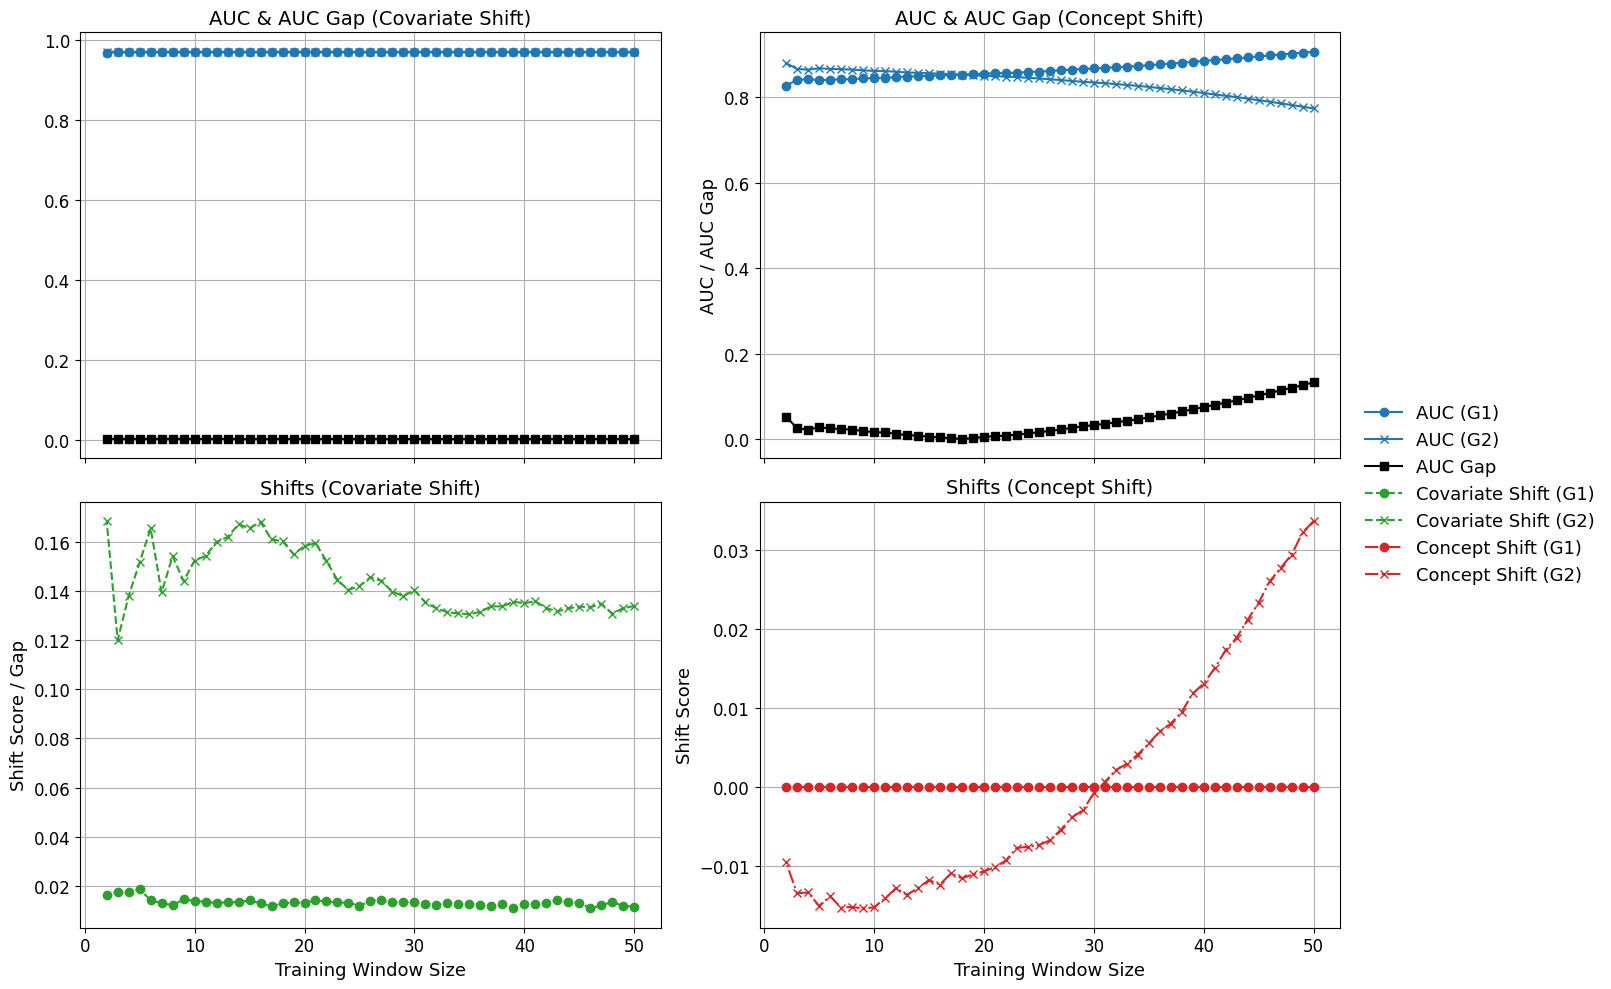

In [33]:

df1 = df_fairness.copy().sort_values('train_year')          # concept-only
df1['window_size'] = 50 - df1['train_year'] + 1

df2 = df_covariate_fairness.copy().sort_values('train_year')  # covariate-only
df2['window_size'] = 50 - df2['train_year'] + 1

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# =================== Left Column: Concept-only ===================

axes[0, 1].plot(df1['window_size'], df1['auc_gender0'],
                label='AUC (G1)', color='tab:blue', marker='o')
axes[0, 1].plot(df1['window_size'], df1['auc_gender1'],
                label='AUC (G2)', color='tab:blue', marker='x', linestyle='-')
axes[0, 1].plot(df1['window_size'], df1['auc_gap'],
                label='AUC Gap', color='black', marker='s', linestyle='-')
axes[0, 1].set_title('AUC & AUC Gap (Concept Shift)', fontsize=14)
axes[0, 1].set_ylabel('AUC / AUC Gap', fontsize=13)
axes[0, 1].grid(True)
axes[0, 1].tick_params(labelsize=12)

axes[1, 1].plot(df1['window_size'], df1['js_resid_gender0'],
                label='Concept Shift (G1)', color='tab:red', linestyle='-.', marker='o')
axes[1, 1].plot(df1['window_size'], df1['js_resid_gender1'],
                label='Concept Shift (G2)', color='tab:red', linestyle='-.', marker='x')
axes[1, 1].set_title('Shifts (Concept Shift)', fontsize=14)
axes[1, 1].set_xlabel('Training Window Size', fontsize=13)
axes[1, 1].set_ylabel('Shift Score', fontsize=13)
axes[1, 1].grid(True)
axes[1, 1].tick_params(labelsize=12)

# =================== Right Column: Covariate-only ===================

axes[0, 0].plot(df2['window_size'], df2['auc_gender0'],
                label='AUC (G1)', color='tab:blue', marker='o')
axes[0, 0].plot(df2['window_size'], df2['auc_gender1'],
                label='AUC (G2)', color='tab:blue', marker='x', linestyle='-')
axes[0, 0].plot(df2['window_size'], df2['auc_gap'],
                label='AUC Gap', color='black', marker='s', linestyle='-')
axes[0, 0].set_title('AUC & AUC Gap (Covariate Shift)', fontsize=14)
axes[0, 0].grid(True)
axes[0, 0].tick_params(labelsize=12)

axes[1, 0].plot(df2['window_size'], df2['unified_cov_shift_gender0'],
                label='Covariate Shift (G1)', color='tab:green', linestyle='--', marker='o')
axes[1, 0].plot(df2['window_size'], df2['unified_cov_shift_gender1'],
                label='Covariate Shift (G2)', color='tab:green', linestyle='--', marker='x')
axes[1, 0].set_title('Shifts (Covariate Shift)', fontsize=14)
axes[1, 0].set_xlabel('Training Window Size', fontsize=13)
axes[1, 0].set_ylabel('Shift Score / Gap', fontsize=13)
axes[1, 0].grid(True)
axes[1, 0].tick_params(labelsize=12)

# --- Global legend ---
handles, labels = [], []
for ax in axes.flatten():
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels:
            handles.append(hi); labels.append(li)

fig.legend(handles, labels, loc='center right',
           bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize=13)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


### Intersectional

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde, ks_2samp, wasserstein_distance
from scipy.spatial.distance import jensenshannon
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

def estimate_p_y_knn(X_train, y_train, X_query, k=100):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_train)
    _, idxs = nbrs.kneighbors(X_query)
    return y_train[idxs].mean(axis=1)

def kl_divergence_kde(p, q, n_points=1000):
    xmin = min(p.min(), q.min())
    xmax = max(p.max(), q.max())
    grid = np.linspace(xmin, xmax, n_points)
    kde_p = gaussian_kde(p)
    kde_q = gaussian_kde(q)
    pdf_p = kde_p(grid) + 1e-10
    pdf_q = kde_q(grid) + 1e-10
    return np.sum(pdf_q * np.log(pdf_q / pdf_p)) * (xmax - xmin) / n_points

def js_divergence_kde(p, q, n_points=1000):
    xmin = min(p.min(), q.min())
    xmax = max(p.max(), q.max())
    grid = np.linspace(xmin, xmax, n_points)
    kde_p = gaussian_kde(p)
    kde_q = gaussian_kde(q)
    pdf_p = kde_p(grid) + 1e-10
    pdf_q = kde_q(grid) + 1e-10
    pdf_p /= pdf_p.sum()
    pdf_q /= pdf_q.sum()
    return jensenshannon(pdf_p, pdf_q)

def compute_concept_shift(train_df, test_df, feature_cols, k=100, n_pca=5):
    X_train = train_df[feature_cols].values
    y_train = train_df['y'].values
    X_test = test_df[feature_cols].values
    y_test = test_df['y'].values
    X_combined = np.vstack([X_train, X_test])
    pca = PCA(n_components=min(n_pca, X_combined.shape[1]))
    X_combined_pca = pca.fit_transform(X_combined)
    X_train_pca = X_combined_pca[:len(X_train)]
    X_test_pca = X_combined_pca[len(X_train):]
    p_train = estimate_p_y_knn(X_train_pca, y_train, X_train_pca, k)
    p_test = estimate_p_y_knn(X_test_pca, y_test, X_test_pca, k)
    return kl_divergence_kde(p_train, p_test), js_divergence_kde(p_train, p_test)

from scipy.stats import chi2_contingency

def cramers_v(conf_matrix):
    chi2 = chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = conf_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings for logistic regression
warnings.simplefilter("ignore", ConvergenceWarning)

def evaluate_degradation(df_all, test_year=100, k=100):
    feature_cols = [col for col in df_all.columns if col.startswith('x')]
    
    # Split continuous and binary
    binary_vars = [col for col in feature_cols if df_all[col].nunique() == 2]
    continuous_vars = [col for col in feature_cols if col not in binary_vars]
    
    results = []
    test_df = df_all[df_all['year'] == test_year]

    for y in range(test_year - 1, 0, -1):
        train_df = df_all[df_all['year'].between(y, test_year - 1)]

        if train_df['y'].nunique() < 2 or test_df['y'].nunique() < 2:
            continue

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(train_df[feature_cols], train_df['y'])
        y_prob = model.predict_proba(test_df[feature_cols])[:, 1]
        auc = roc_auc_score(test_df['y'], y_prob)


        kl_score, js_score = compute_concept_shift(train_df, test_df, feature_cols, k=k)

        # --- Covariate shift: Continuous ---
        try:
            scaler = StandardScaler().fit(train_df[continuous_vars])
            train_scaled = scaler.transform(train_df[continuous_vars])
            test_scaled = scaler.transform(test_df[continuous_vars])
            pca = PCA(n_components=min(5, len(continuous_vars)))
            train_pca = pca.fit_transform(train_scaled)
            test_pca = pca.transform(test_scaled)
            ks_vals = [ks_2samp(train_pca[:, i], test_pca[:, i]).statistic for i in range(pca.n_components_)]
            cov_shift_cont = np.mean(ks_vals)
        except:
            cov_shift_cont = np.nan

        # --- Covariate shift: Binary ---
        delta_props = []
        cramers_vs = []
        try:
            for b in binary_vars:
                if b in train_df.columns and b in test_df.columns:
                    p1 = train_df[b].mean()
                    p2 = test_df[b].mean()
                    delta_props.append(abs(p1 - p2))

                    ct = pd.crosstab(df_all[df_all['year'].isin([y, test_year])]['year'],
                                     df_all[df_all['year'].isin([y, test_year])][b])
                    if ct.shape == (2, 2):
                        cramers_vs.append(cramers_v(ct))

            if delta_props and cramers_vs:
                cov_shift_bin = (np.mean(delta_props) + np.mean(cramers_vs)) / 2
            else:
                cov_shift_bin = np.nan
        except:
            cov_shift_bin = np.nan

        # --- Unified Covariate Shift ---
        unified_cov_shift = np.nanmean([cov_shift_cont, cov_shift_bin])

        results.append({
            'window_size': test_year - y,
            'auc': auc,
            'concept_shift_js': js_score,
            'covariate_shift_cont': cov_shift_cont,
            'covariate_shift_bin': cov_shift_bin,
            'covariate_shift': unified_cov_shift
        })

    return pd.DataFrame(results)



# --- Residualize concept shift using covariate shift ---
def residualize_concept_shift(df):
    df_clean = df.dropna(subset=['concept_shift_js', 'covariate_shift'])
    X = df_clean[['covariate_shift']]
    y = df_clean['concept_shift_js']
    rf = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
    y_pred = cross_val_predict(rf, X, y, cv=5)
    df_clean['concept_shift_js_resid'] = y - y_pred
    return df_clean



In [ ]:
def simulate_dual_axis_concept_shift(n_years=50, n_samples_per_year=5000,
                                     n_cont=15, n_bin=4, seed=42):
    np.random.seed(seed)
    all_data = []

    n_features = n_cont + n_bin
    coef_base = np.random.uniform(-2, 2, size=n_features)
    coef_gender1 = np.random.uniform(-2, 2, size=n_features)  # shift for gender=1
    coef_urm1 = np.random.uniform(-2, 2, size=n_features)     # shift for urm=1

    for year in range(1, n_years + 1):
        alpha = (year - 1) / (n_years - 1)

        # Features
        X_cont = np.random.normal(0, 1, size=(n_samples_per_year, n_cont))
        X_bin = np.random.binomial(1, 0.5, size=(n_samples_per_year, n_bin))
        X = np.hstack([X_cont, X_bin])

        # Demographics
        gender = np.random.binomial(1, 0.5, size=(n_samples_per_year, 1))
        urm = np.random.binomial(1, 0.5, size=(n_samples_per_year, 1))

        logits = np.zeros(n_samples_per_year)
        for i in range(n_samples_per_year):
            coef = coef_base.copy()

            # Apply gender-specific concept shift if gender=1
            if gender[i] == 1:
                coef = (1 - alpha) * coef + alpha * coef_gender1

            # Apply urm-specific concept shift if urm=1
            if urm[i] == 1:
                coef = (1 - alpha) * coef + alpha * coef_urm1

            logits[i] = X[i] @ coef

        probs = expit(logits)
        y = np.random.binomial(1, probs)

        df = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(n_features)])
        df['gender'] = gender.flatten()
        df['urm'] = urm.flatten()
        df['y'] = y
        df['year'] = year
        all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

# Simulate data with intersectional concept shift only
df_intersec_concept_shift = simulate_dual_axis_concept_shift()

# Define features and demographic columns
feature_cols = [col for col in df_intersec_concept_shift.columns if col.startswith('x')]
gender_col = 'gender'
urm_col = 'urm'
test_year = 50

def compute_intersec_shift_metrics(df_all, test_year, feature_cols, k=100):
    shift_rows = []
    test_df = df_all[df_all['year'] == test_year]

    binary_vars = [col for col in feature_cols if df_all[col].nunique() == 2]
    continuous_vars = [col for col in feature_cols if col not in binary_vars]

    for y in range(test_year - 1, 0, -1):
        shift_row = {'train_year': y}
        train_df = df_all[df_all['year'].between(y, test_year - 1)]

        for g in [0, 1]:
            for u in [0, 1]:
                group_label = f'gender{g}_urm{u}'

                train_g = train_df[(train_df['gender'] == g) & (train_df['urm'] == u)]
                test_g = test_df[(test_df['gender'] == g) & (test_df['urm'] == u)]

                # --- Concept shift ---
                if len(train_g) >= k and len(test_g) >= k:
                    shift_row[f'js_{group_label}'] = compute_concept_shift(train_g, test_g, feature_cols, k=k)
                else:
                    shift_row[f'js_{group_label}'] = np.nan

                # --- Covariate shift ---
                try:
                    cont_train = train_g[continuous_vars].dropna()
                    cont_test = test_g[continuous_vars].dropna()
                    if len(cont_train) > 0 and len(cont_test) > 0:
                        scaler = StandardScaler().fit(cont_train)
                        train_scaled = scaler.transform(cont_train)
                        test_scaled = scaler.transform(cont_test)

                        pca = PCA(n_components=min(5, len(continuous_vars)))
                        train_pca = pca.fit_transform(train_scaled)
                        test_pca = pca.transform(test_scaled)

                        ks_vals = [ks_2samp(train_pca[:, i], test_pca[:, i]).statistic for i in range(pca.n_components_)]
                        shift_row[f'cov_shift_cont_{group_label}'] = np.mean(ks_vals)
                    else:
                        shift_row[f'cov_shift_cont_{group_label}'] = np.nan
                except:
                    shift_row[f'cov_shift_cont_{group_label}'] = np.nan

                try:
                    delta_props = []
                    cramers_vs = []
                    for b in binary_vars:
                        if b not in train_g.columns or b not in test_g.columns:
                            continue
                        p_train = train_g[b].mean()
                        p_test = test_g[b].mean()
                        delta_props.append(abs(p_train - p_test))

                        df_temp = pd.concat([
                            df_all[(df_all['year'] == y) & (df_all['gender'] == g) & (df_all['urm'] == u)],
                            df_all[(df_all['year'] == test_year) & (df_all['gender'] == g) & (df_all['urm'] == u)]
                        ])
                        ct = pd.crosstab(df_temp['year'], df_temp[b])
                        if ct.shape == (2, 2):
                            cramers_vs.append(cramers_v(ct))

                    if delta_props and cramers_vs:
                        shift_row[f'cov_shift_bin_{group_label}'] = (np.mean(delta_props) + np.mean(cramers_vs)) / 2
                    else:
                        shift_row[f'cov_shift_bin_{group_label}'] = np.nan
                except:
                    shift_row[f'cov_shift_bin_{group_label}'] = np.nan

                cont_val = shift_row.get(f'cov_shift_cont_{group_label}', np.nan)
                bin_val = shift_row.get(f'cov_shift_bin_{group_label}', np.nan)
                shift_row[f'unified_cov_shift_{group_label}'] = np.nanmean([cont_val, bin_val])

        shift_rows.append(shift_row)

    return pd.DataFrame(shift_rows)

def compute_intersec_auc_all_groups(df_all, test_year, feature_cols):
    results = []

    for y in range(test_year - 1, 0, -1):
        train_df = df_all[df_all['year'].between(y, test_year - 1)]
        test_df = df_all[df_all['year'] == test_year]

        group_aucs = {}
        auc_values = []

        for gender in [0, 1]:
            for urm in [0, 1]:
                group_key = f'auc_gender{gender}_urm{urm}'
                train_g = train_df[(train_df['gender'] == gender) & (train_df['urm'] == urm)]
                test_g = test_df[(test_df['gender'] == gender) & (test_df['urm'] == urm)]

                if test_g['y'].nunique() < 2 or len(test_g) == 0:
                    group_aucs[group_key] = np.nan
                    continue

                try:
                    model = LogisticRegression(max_iter=1000, solver='lbfgs')
                    model.fit(train_g[feature_cols], train_g['y'])
                    y_prob = model.predict_proba(test_g[feature_cols])[:, 1]
                    auc = roc_auc_score(test_g['y'], y_prob)
                    group_aucs[group_key] = auc
                    auc_values.append(auc)
                except:
                    group_aucs[group_key] = np.nan

        group_aucs['train_year'] = y
        group_aucs['auc_gap_intersec'] = (
            np.max(auc_values) - np.min(auc_values) if len(auc_values) >= 2 else np.nan
        )

        results.append(group_aucs)

    return pd.DataFrame(results)

df_intersec_shift = compute_intersec_shift_metrics(df_intersec_concept_shift, test_year, feature_cols)
df_intersec_auc = compute_intersec_auc_all_groups(df_intersec_concept_shift, test_year, feature_cols)
df_intersec_fairness = pd.merge(df_intersec_shift, df_intersec_auc, on='train_year')



In [36]:
# Simulate data with intersectional concept shift only
df_intersec_concept_shift = simulate_dual_axis_concept_shift()

# Define features and demographic columns
feature_cols = [col for col in df_intersec_concept_shift.columns if col.startswith('x')]
gender_col = 'gender'
urm_col = 'urm'
test_year = 50


In [37]:
def compute_intersec_shift_metrics(df_all, test_year, feature_cols, k=100):
    shift_rows = []
    test_df = df_all[df_all['year'] == test_year]

    binary_vars = [col for col in feature_cols if df_all[col].nunique() == 2]
    continuous_vars = [col for col in feature_cols if col not in binary_vars]

    for y in range(test_year - 1, 0, -1):
        shift_row = {'train_year': y}
        train_df = df_all[df_all['year'].between(y, test_year - 1)]

        for g in [0, 1]:
            for u in [0, 1]:
                group_label = f'gender{g}_urm{u}'

                train_g = train_df[(train_df['gender'] == g) & (train_df['urm'] == u)]
                test_g = test_df[(test_df['gender'] == g) & (test_df['urm'] == u)]

                # --- Concept shift ---
                if len(train_g) >= k and len(test_g) >= k:
                    shift_row[f'js_{group_label}'] = compute_concept_shift(train_g, test_g, feature_cols, k=k)
                else:
                    shift_row[f'js_{group_label}'] = np.nan

                # --- Covariate shift ---
                # Continuous via PCA + KS
                try:
                    cont_train = train_g[continuous_vars].dropna()
                    cont_test = test_g[continuous_vars].dropna()
                    if len(cont_train) > 0 and len(cont_test) > 0:
                        scaler = StandardScaler().fit(cont_train)
                        train_scaled = scaler.transform(cont_train)
                        test_scaled = scaler.transform(cont_test)

                        pca = PCA(n_components=min(5, len(continuous_vars)))
                        train_pca = pca.fit_transform(train_scaled)
                        test_pca = pca.transform(test_scaled)

                        ks_vals = [ks_2samp(train_pca[:, i], test_pca[:, i]).statistic for i in range(pca.n_components_)]
                        shift_row[f'cov_shift_cont_{group_label}'] = np.mean(ks_vals)
                    else:
                        shift_row[f'cov_shift_cont_{group_label}'] = np.nan
                except:
                    shift_row[f'cov_shift_cont_{group_label}'] = np.nan

                # Binary via prop diff + Cramér’s V
                try:
                    delta_props = []
                    cramers_vs = []
                    for b in binary_vars:
                        if b not in train_g.columns or b not in test_g.columns:
                            continue
                        p_train = train_g[b].mean()
                        p_test = test_g[b].mean()
                        delta_props.append(abs(p_train - p_test))

                        df_temp = pd.concat([
                            df_all[(df_all['year'] == y) & (df_all['gender'] == g) & (df_all['urm'] == u)],
                            df_all[(df_all['year'] == test_year) & (df_all['gender'] == g) & (df_all['urm'] == u)]
                        ])
                        ct = pd.crosstab(df_temp['year'], df_temp[b])
                        if ct.shape == (2, 2):
                            cramers_vs.append(cramers_v(ct))

                    if delta_props and cramers_vs:
                        shift_row[f'cov_shift_bin_{group_label}'] = (np.mean(delta_props) + np.mean(cramers_vs)) / 2
                    else:
                        shift_row[f'cov_shift_bin_{group_label}'] = np.nan
                except:
                    shift_row[f'cov_shift_bin_{group_label}'] = np.nan

                # Unified score
                cont_val = shift_row.get(f'cov_shift_cont_{group_label}', np.nan)
                bin_val = shift_row.get(f'cov_shift_bin_{group_label}', np.nan)
                shift_row[f'unified_cov_shift_{group_label}'] = np.nanmean([cont_val, bin_val])

        shift_rows.append(shift_row)

    return pd.DataFrame(shift_rows)


In [38]:
def compute_intersec_auc_all_groups(df_all, test_year, feature_cols):
    results = []

    for y in range(test_year - 1, 0, -1):
        train_df = df_all[df_all['year'].between(y, test_year - 1)]
        test_df = df_all[df_all['year'] == test_year]

        group_aucs = {}
        auc_values = []

        for gender in [0, 1]:
            for urm in [0, 1]:
                group_key = f'auc_gender{gender}_urm{urm}'
                train_g = train_df[(train_df['gender'] == gender) & (train_df['urm'] == urm)]
                test_g = test_df[(test_df['gender'] == gender) & (test_df['urm'] == urm)]

                if test_g['y'].nunique() < 2 or len(test_g) == 0:
                    group_aucs[group_key] = np.nan
                    continue

                try:
                    model = LogisticRegression(max_iter=1000, solver='lbfgs')
                    model.fit(train_g[feature_cols], train_g['y'])
                    y_prob = model.predict_proba(test_g[feature_cols])[:, 1]
                    auc = roc_auc_score(test_g['y'], y_prob)
                    group_aucs[group_key] = auc
                    auc_values.append(auc)
                except:
                    group_aucs[group_key] = np.nan

        group_aucs['train_year'] = y
        group_aucs['auc_gap_intersec'] = (
            np.max(auc_values) - np.min(auc_values) if len(auc_values) >= 2 else np.nan
        )

        results.append(group_aucs)

    return pd.DataFrame(results)


In [39]:
import statsmodels.api as sm

def residualize_shift(df, js_col, cov_col, resid_col):
    valid = df[[js_col, cov_col]].dropna()
    if valid.empty:
        df[resid_col] = np.nan
        return df

    X = sm.add_constant(valid[[cov_col]])
    y = valid[js_col]
    model = sm.OLS(y, X).fit()
    residuals = y - model.predict(X)
    df.loc[valid.index, resid_col] = residuals
    return df


In [40]:
df_intersec_shift = compute_intersec_shift_metrics(df_intersec_concept_shift, test_year, feature_cols)
df_intersec_auc = compute_intersec_auc_all_groups(df_intersec_concept_shift, test_year, feature_cols)
df_intersec_fairness = pd.merge(df_intersec_shift, df_intersec_auc, on='train_year')

In [ ]:
def simulate_additive_shift_dual_group(n_years=50, n_samples_per_year=5000,
                                       n_cont=15, n_bin=4, seed=42):
    np.random.seed(seed)
    all_data = []
    n_features = n_cont + n_bin

    coef_base = np.random.uniform(-2, 2, size=n_features)
    coef_gender1 = np.random.uniform(-4, -2, size=n_features)  
    coef_urm1 = np.random.uniform(2, 4, size=n_features)       

    for year in range(1, n_years + 1):
        alpha = (year - 1) / (n_years - 1)


        X_cont = np.random.normal(0, 1, size=(n_samples_per_year, n_cont))
        X_bin = np.random.binomial(1, 0.5, size=(n_samples_per_year, n_bin))
        X = np.hstack([X_cont, X_bin])

        gender = np.random.binomial(1, 0.5, size=(n_samples_per_year, 1))
        urm = np.random.binomial(1, 0.5, size=(n_samples_per_year, 1))

        logits = np.zeros(n_samples_per_year)

        for i in range(n_samples_per_year):
            coef = coef_base.copy()

            if gender[i] == 1:
                coef += alpha * (coef_gender1 - coef_base)
            if urm[i] == 1:
                coef += alpha * (coef_urm1 - coef_base)

            logits[i] = X[i] @ coef

        probs = expit(logits)
        y = np.random.binomial(1, probs)

        df = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(n_features)])
        df['gender'] = gender.flatten()
        df['urm'] = urm.flatten()
        df['y'] = y
        df['year'] = year
        all_data.append(df)

    return pd.concat(all_data, ignore_index=True)


In [ ]:

df_intersec_concept_shift_ad = simulate_additive_shift_dual_group()

feature_cols = [col for col in df_intersec_concept_shift_ad.columns if col.startswith('x')]
gender_col = 'gender'
urm_col = 'urm'
test_year = 50


In [43]:
df_intersec_shift_ad = compute_intersec_shift_metrics(df_intersec_concept_shift_ad, test_year, feature_cols)
df_intersec_auc_ad = compute_intersec_auc_all_groups(df_intersec_concept_shift_ad, test_year, feature_cols)


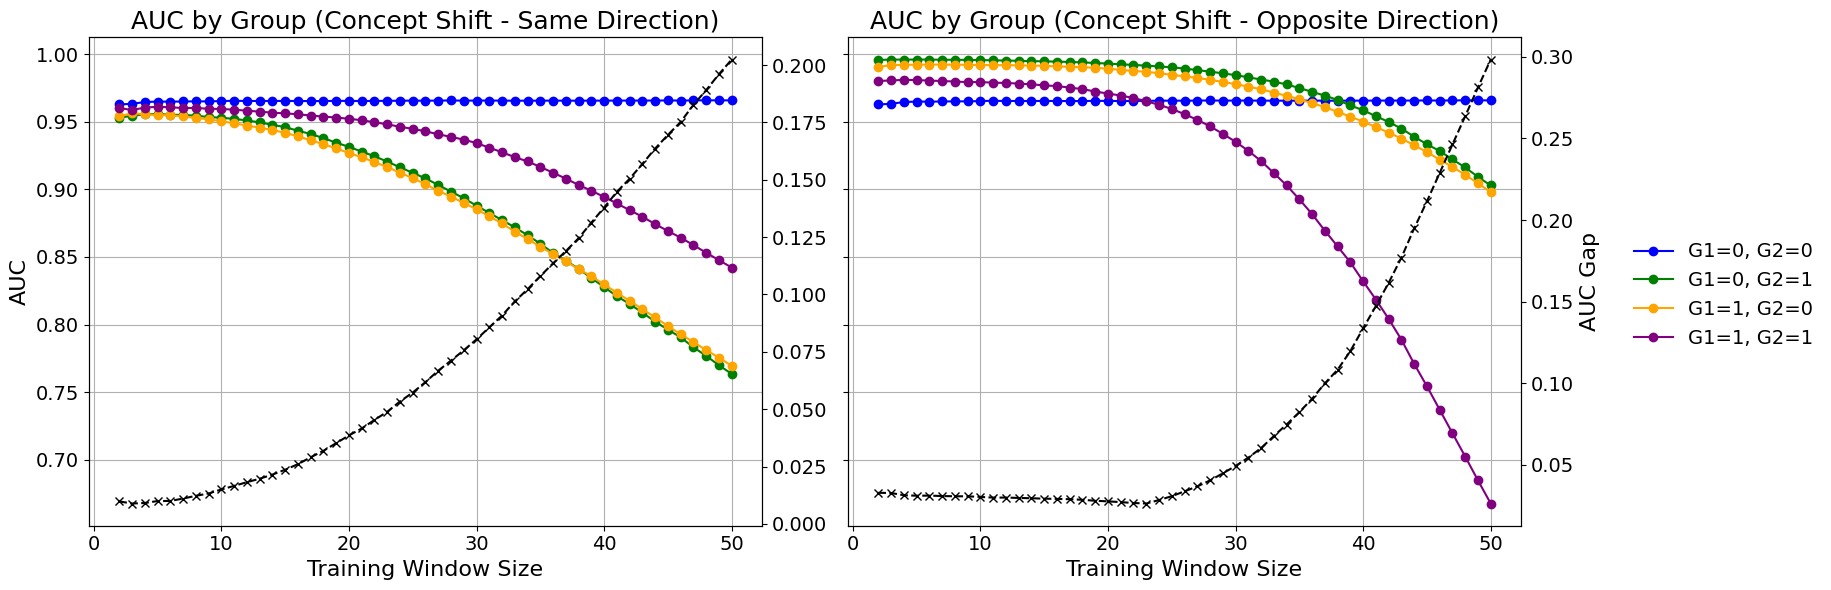

In [ ]:
group_colors = {
    'G1=0, G2=0': 'blue',
    'G1=0, G2=1': 'green',
    'G1=1, G2=0': 'orange',
    'G1=1, G2=1': 'purple'
}

df_auc_1 = df_intersec_auc.dropna().copy()
df_auc_2 = df_intersec_auc_ad.dropna().copy()
df_auc_1['training_window_size'] = 50 - df_auc_1['train_year'] + 1
df_auc_2['training_window_size'] = 50 - df_auc_2['train_year'] + 1

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

title_size = 18
label_size = 16
tick_size = 14
legend_size = 14
xticks = [0, 10, 20, 30, 40, 50]

ax = axes[0]
ax.plot(df_auc_1['training_window_size'], df_auc_1['auc_gender0_urm0'], label='G1=0, G2=0', color=group_colors['G1=0, G2=0'], marker='o')
ax.plot(df_auc_1['training_window_size'], df_auc_1['auc_gender0_urm1'], label='G1=0, G2=1', color=group_colors['G1=0, G2=1'], marker='o')
ax.plot(df_auc_1['training_window_size'], df_auc_1['auc_gender1_urm0'], label='G1=1, G2=0', color=group_colors['G1=1, G2=0'], marker='o')
ax.plot(df_auc_1['training_window_size'], df_auc_1['auc_gender1_urm1'], label='G1=1, G2=1', color=group_colors['G1=1, G2=1'], marker='o')
ax.set_title("AUC by Group (Concept Shift - Same Direction)", fontsize=title_size)
ax.set_xlabel("Training Window Size", fontsize=label_size)
ax.set_ylabel("AUC", fontsize=label_size)
ax.tick_params(axis='both', labelsize=tick_size)
ax.set_xticks(xticks)
ax.grid(True)

ax2 = ax.twinx()
ax2.plot(df_auc_1['training_window_size'], df_auc_1['auc_gap_intersec'], color='black', linestyle='--', marker='x', label='AUC Gap')
ax2.tick_params(axis='y', labelcolor='black', labelsize=tick_size)
ax2.set_xlim(ax.get_xlim())

ax = axes[1]
ax.plot(df_auc_2['training_window_size'], df_auc_2['auc_gender0_urm0'], color=group_colors['G1=0, G2=0'], marker='o')
ax.plot(df_auc_2['training_window_size'], df_auc_2['auc_gender0_urm1'], color=group_colors['G1=0, G2=1'], marker='o')
ax.plot(df_auc_2['training_window_size'], df_auc_2['auc_gender1_urm0'], color=group_colors['G1=1, G2=0'], marker='o')
ax.plot(df_auc_2['training_window_size'], df_auc_2['auc_gender1_urm1'], color=group_colors['G1=1, G2=1'], marker='o')
ax.set_title("AUC by Group (Concept Shift - Opposite Direction)", fontsize=title_size)
ax.set_xlabel("Training Window Size", fontsize=label_size)
ax.tick_params(axis='both', labelsize=tick_size)
ax.set_xticks(xticks)
ax.grid(True)

ax2 = ax.twinx()
ax2.plot(df_auc_2['training_window_size'], df_auc_2['auc_gap_intersec'], color='black', linestyle='--', marker='x')
ax2.set_ylabel("AUC Gap", fontsize=label_size)
ax2.tick_params(axis='y', labelcolor='black', labelsize=tick_size)
ax2.set_xlim(ax.get_xlim())

handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)

fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=legend_size)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

